Written by Sunoy Sanyal and Cihan Arslanargın on 18.03.2025

Problem description:

This is a two-stage problem: first, the deployment of the healthcare units is optimized, and then, in the second stage, the distribution of equipment from the depot to the units is planned.

In [1]:
filepath="sabanci_ie_opt_challenge_2025_-_instances/FINAL_Depot Location Updated/Instance_1.txt"
writepath = "Solutions"

# pip commands

In [2]:
!pip install gurobipy


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

## Libs

In [3]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt
import os


## Data

In [4]:
def read_instance(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    N, M = map(int, lines[0].split())
    depot = tuple(map(float, lines[1].split()[1:]))

    communities = {}
    populations = {}
    for line in lines[2:]:
        values = list(map(float, line.split()))
        node_index, x, y, capacity, population = values
        communities[node_index] = {'coords': (x, y), 'capacity': capacity, 'population': population}
        populations[node_index] = population

    # Compute distance matrix
    distance_matrix = {
        (i, j): euclidean_distance(communities[i]['coords'], communities[j]['coords'])
        for i in communities for j in communities
    }

    return N, M, depot, communities, populations, distance_matrix

def write_solution(write_filepath, read_filepath, healthcare_units, assignments, stage1_obj, routes=[0, 0], stage2_obj=0):
    # Extract instance name
    instance_name = os.path.basename(read_filepath).replace("Instance_", "Sol_Instance_")
    solution_file = os.path.join(write_filepath, instance_name)
    
    with open(solution_file, 'w') as f:
        f.write("Stage-1:\n")
        for hc in healthcare_units:
            assigned = assignments[hc]
            f.write(f"Healthcenter deployed at {hc}: Communities Assigned = {{" + ", ".join(map(str, assigned)) + "}}\n")
        f.write(f"Objective Value: {stage1_obj}\n\n")
        
        f.write("Stage-2:\n")
        for i, route in enumerate(routes, 1):
            route_str = " -> ".join(["Depot" if hc == 0 else f"Healthcenter at {hc}" for hc in route])
            f.write(f"Route {i}: {route_str}\n")
        f.write(f"Objective Value: {stage2_obj}\n")

# Sample usage:
# N, M, depot, communities = read_instance("Instance_0.txt")
# print(f"Parsed Instance: N={N}, M={M}, Depot={depot}, Communities={communities}")

def euclidean_distance(loc1, loc2):
    return np.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

def extract_routes(soln_route_pairs):
    routes = []
    remaining_edges = set(soln_route_pairs)
    
    while remaining_edges:
        current_route = []
        for edge in remaining_edges:
            if edge[0] == 0:  # Start from depot
                current_route.append(edge[0])
                current_route.append(edge[1])
                remaining_edges.remove(edge)
                break
        
        while True:
            next_edges = [e for e in remaining_edges if e[0] == current_route[-1]]
            if not next_edges:
                break
            next_edge = next_edges[0]
            current_route.append(next_edge[1])
            remaining_edges.remove(next_edge)
        
        routes.append(current_route)
    
    return routes




# Stage 1


---




## Math Formulation



**Decision Variables**

  $x_{ij}$​: Binary variable, equal to 1 if community $i$ is assigned to healthcare unit $j$, and 0 otherwise.

  $y_j$​: Binary variable, equal to 1 if a healthcare unit is deployed at community $j$, and 0 otherwise.

  ⁡$D_{max}$​: The maximum population-weighted distance across all communities (objective function target).

  **Parameters**

  $N$: Number of communities.
  
  $M$: Number of healthcare units to be deployed.
  
  $C$: Maximum capacity of each healthcare unit (i.e., the maximum number of people it can serve).
  
  $P_i$​: Population of community $i$.
  
  $d_{ij}$​: Euclidean distance between community $i$ and community $j$ (where a healthcare unit may be placed).


**Objective Function**

Minimize the maximum population-weighted distance traveled by any community:

$$ min \, ⁡D_{max}
$$⁡


**Constraints**


1.   

Each community must be assigned to one healthcare unit:
$$\Sigma^N_{j=1}x_{ij}=1, \quad \forall i∈\{1,…,N\}
$$

*Each community must be assigned to exactly one healthcare unit.*

---
2.   

A community can only be assigned to a healthcare unit if that unit is deployed:
$$x_{ij} \leq y_j,\quad ∀i,j∈\{1,…,N\}$$

*If a healthcare unit is not deployed at $j$, no community can be assigned to it.*

---
3.









The total number of healthcare units deployed must be exactly M:
$$\Sigma^N_{j=1}y_j=M
$$

---
4.


The capacity of each deployed healthcare unit must not be exceeded:
$$\Sigma^N_{i=1} P_i x_{ij} \leq Cy_j, \quad ∀j∈\{1,…,N\}
$$

The total population assigned to a unit must not exceed its capacity.

---
5.


Definition of the population-weighted distance:
$$d_i >= x_{ij} P_i d_{ij}, \quad ∀i,j∈\{1,…,N\}
$$

This calculates the effective weighted distance each community needs to travel.

---
6.

Ensuring the objective function is the maximum of all population-weighted distances:
$$d_i≤D_{max⁡},\quad ∀i∈\{1,…,N\}
$$

Combining cons 5 & 6


## Code

In [5]:
N, M, depot, communities, populations, distance_matrix = read_instance(filepath)
#print(f"Parsed Instance: N={N}, M={M}, Depot={depot}, Communities={communities}")
#print(f"Computed Distance Matrix: {distance_matrix}")
Capacity = communities[1]['capacity']
# Create Gurobi model
model = gp.Model("Healthcare_Deployment")

# Decision variables
x = model.addVars(N, N, vtype=GRB.BINARY, name="x")  # Assignment variables
y = model.addVars(N, vtype=GRB.BINARY, name="y")      # Deployment variables
# d = model.addVars(N, vtype=GRB.CONTINUOUS, name="d")  # Weighted distance per community
D_max = model.addVar(vtype=GRB.CONTINUOUS, name="D_max")  # Maximum weighted distance

# Objective: Minimize maximum population-weighted distance
model.setObjective(D_max, GRB.MINIMIZE)
# model.setObjective(gp.quicksum(d[i] for i in range(N)), GRB.MINIMIZE)

# Constraints
# 1. Each community is assigned to exactly one healthcare unit
for i in range(N):
    model.addConstr(gp.quicksum(x[i, j] for j in range(N)) == 1, name=f"Assign_{i}")

# 2. A community can only be assigned to an open healthcare unit
#for i in range(N):
#    for j in range(N):
#        model.addConstr(x[i, j] <= y[j], name=f"AssignIfOpen_{i}_{j}")

# 3. Exactly M healthcare units must be deployed
model.addConstr(gp.quicksum(y[j] for j in range(N)) == M, name="UnitCount")

# 4. Capacity constraint for each deployed unit
for j in range(N):
    model.addConstr(gp.quicksum(populations[i+1] * x[i, j] for i in range(N)) <= Capacity * y[j], name=f"Capacity_{j}")

# 5. Define population-weighted distances
for i in range(N):
  for j in range(N):
    model.addConstr(D_max >= x[i, j] * populations[i+1] * distance_matrix[(i+1, j+1)], name=f"Distance_{i}")
#for i in range(N):
#    model.addConstr(D_max >= d[i])



# Solve the model
model.optimize()
assignments = {}
healthcare_units = []
# Print results
if model.status == GRB.OPTIMAL:
    print(f"Optimal Maximum Population-Weighted Distance: {D_max.x}")
    #print("Healthcare Units are deployed at communities:")
    for j in range(N):
        if y[j].x > 0.5:
            #print(f"- Community {j+1} at location {communities[j]['coords']}")
            healthcare_units.append(j+1)
            assignments[j+1] = []
    #print("Assignments:")
    for i in range(N):
        for j in range(N):
            if x[i, j].x > 0.5:
                #print(f"Community {i+1} is assigned to Healthcare Unit at Community {j+1}")
                assignments[j+1].append(i+1)
    write_solution(writepath, filepath, healthcare_units, assignments, D_max.x, routes=[], stage2_obj=0)
else:
    print("No optimal solution found.")



Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-07
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 10201 rows, 10101 columns and 40100 nonzeros
Model fingerprint: 0x78fd2efc
Variable types: 1 continuous, 10100 integer (10100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 9900 rows and 0 columns
Presolve time: 0.28s
Presolved: 301 rows, 10101 columns, 30200 nonzeros
Variable types: 1 continuous, 10100 integer (10100 binary)
Found heuristic solution: objective 670462.28718
Found heuristic solution: objective 621934.74418

Root relaxation: objective 0.000000e+00, 276 iterations, 0.02 seconds (0.0


This code does not find multiple optimal solutions, we don't need them but there are lots of solutions since the capacities are relaxed.

## Soln Plotting


In [6]:
print(y)

{0: <gurobi.Var y[0] (value 0.0)>, 1: <gurobi.Var y[1] (value 0.0)>, 2: <gurobi.Var y[2] (value 0.0)>, 3: <gurobi.Var y[3] (value 0.0)>, 4: <gurobi.Var y[4] (value 0.0)>, 5: <gurobi.Var y[5] (value 0.0)>, 6: <gurobi.Var y[6] (value 0.0)>, 7: <gurobi.Var y[7] (value 0.0)>, 8: <gurobi.Var y[8] (value 0.0)>, 9: <gurobi.Var y[9] (value 0.0)>, 10: <gurobi.Var y[10] (value 0.0)>, 11: <gurobi.Var y[11] (value 0.0)>, 12: <gurobi.Var y[12] (value 0.0)>, 13: <gurobi.Var y[13] (value 1.0)>, 14: <gurobi.Var y[14] (value 0.0)>, 15: <gurobi.Var y[15] (value 0.0)>, 16: <gurobi.Var y[16] (value 0.0)>, 17: <gurobi.Var y[17] (value 0.0)>, 18: <gurobi.Var y[18] (value 0.0)>, 19: <gurobi.Var y[19] (value 0.0)>, 20: <gurobi.Var y[20] (value 0.0)>, 21: <gurobi.Var y[21] (value 0.0)>, 22: <gurobi.Var y[22] (value 0.0)>, 23: <gurobi.Var y[23] (value 0.0)>, 24: <gurobi.Var y[24] (value 0.0)>, 25: <gurobi.Var y[25] (value 0.0)>, 26: <gurobi.Var y[26] (value 0.0)>, 27: <gurobi.Var y[27] (value 1.0)>, 28: <gurobi

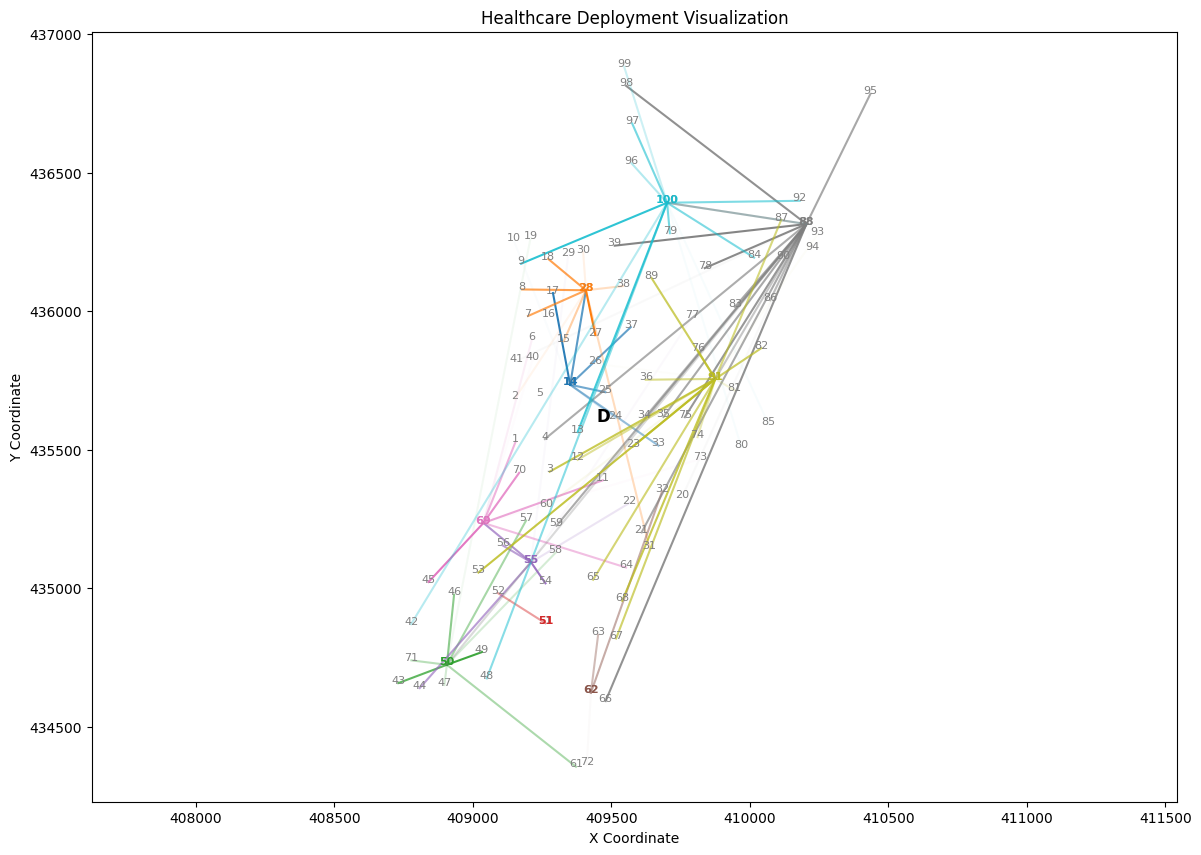

In [7]:
def plot_solution(communities, healthcare_units, assignments, depot):
    plt.figure(figsize=(14, 10))
    colors = plt.get_cmap("tab10")

    # Scale axis to 1:1 ratio
    plt.axis("equal")

    # Plot communities with labels
    for idx, data in communities.items():
        plt.text(data['coords'][0], data['coords'][1], str(int(idx)), fontsize=8, ha='center', color='gray')

    # Plot healthcare units and assign colors
    for i, hc in enumerate(healthcare_units):
        hc_color = colors(i / len(healthcare_units))
        plt.text(communities[hc]['coords'][0], communities[hc]['coords'][1], str(int(hc)), fontsize=8, ha='center', color=hc_color, fontweight='bold')

        # Assign communities to units
        max_d = 0
        max_d_assigned = None
        for assigned in assignments[hc]:
            plt.plot([communities[hc]['coords'][0], communities[assigned]['coords'][0]],
                     [communities[hc]['coords'][1], communities[assigned]['coords'][1]],
                     color=hc_color, linestyle='-', alpha=((distance_matrix[(hc, assigned)]*populations[assigned])/D_max.x))
            if distance_matrix[(hc, assigned)]*populations[assigned] > max_d:
                max_d = distance_matrix[(hc, assigned)]*populations[assigned]
                max_d_assigned = assigned
        #plt.plot([communities[hc]['coords'][0], communities[max_d_assigned]['coords'][0]],
                     #[communities[hc]['coords'][1], communities[max_d_assigned]['coords'][1]],
                    # color=hc_color, linestyle='-', alpha=(distance_matrix[(hc, assigned)]*populations[assigned])/D_max.x)

    # Plot depot
    plt.text(depot[0], depot[1], "D", fontsize=12, ha='center', color='black', fontweight='bold')

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Healthcare Deployment Visualization")
    plt.show()

# Plot the solution
plot_solution(communities, healthcare_units, assignments, depot)


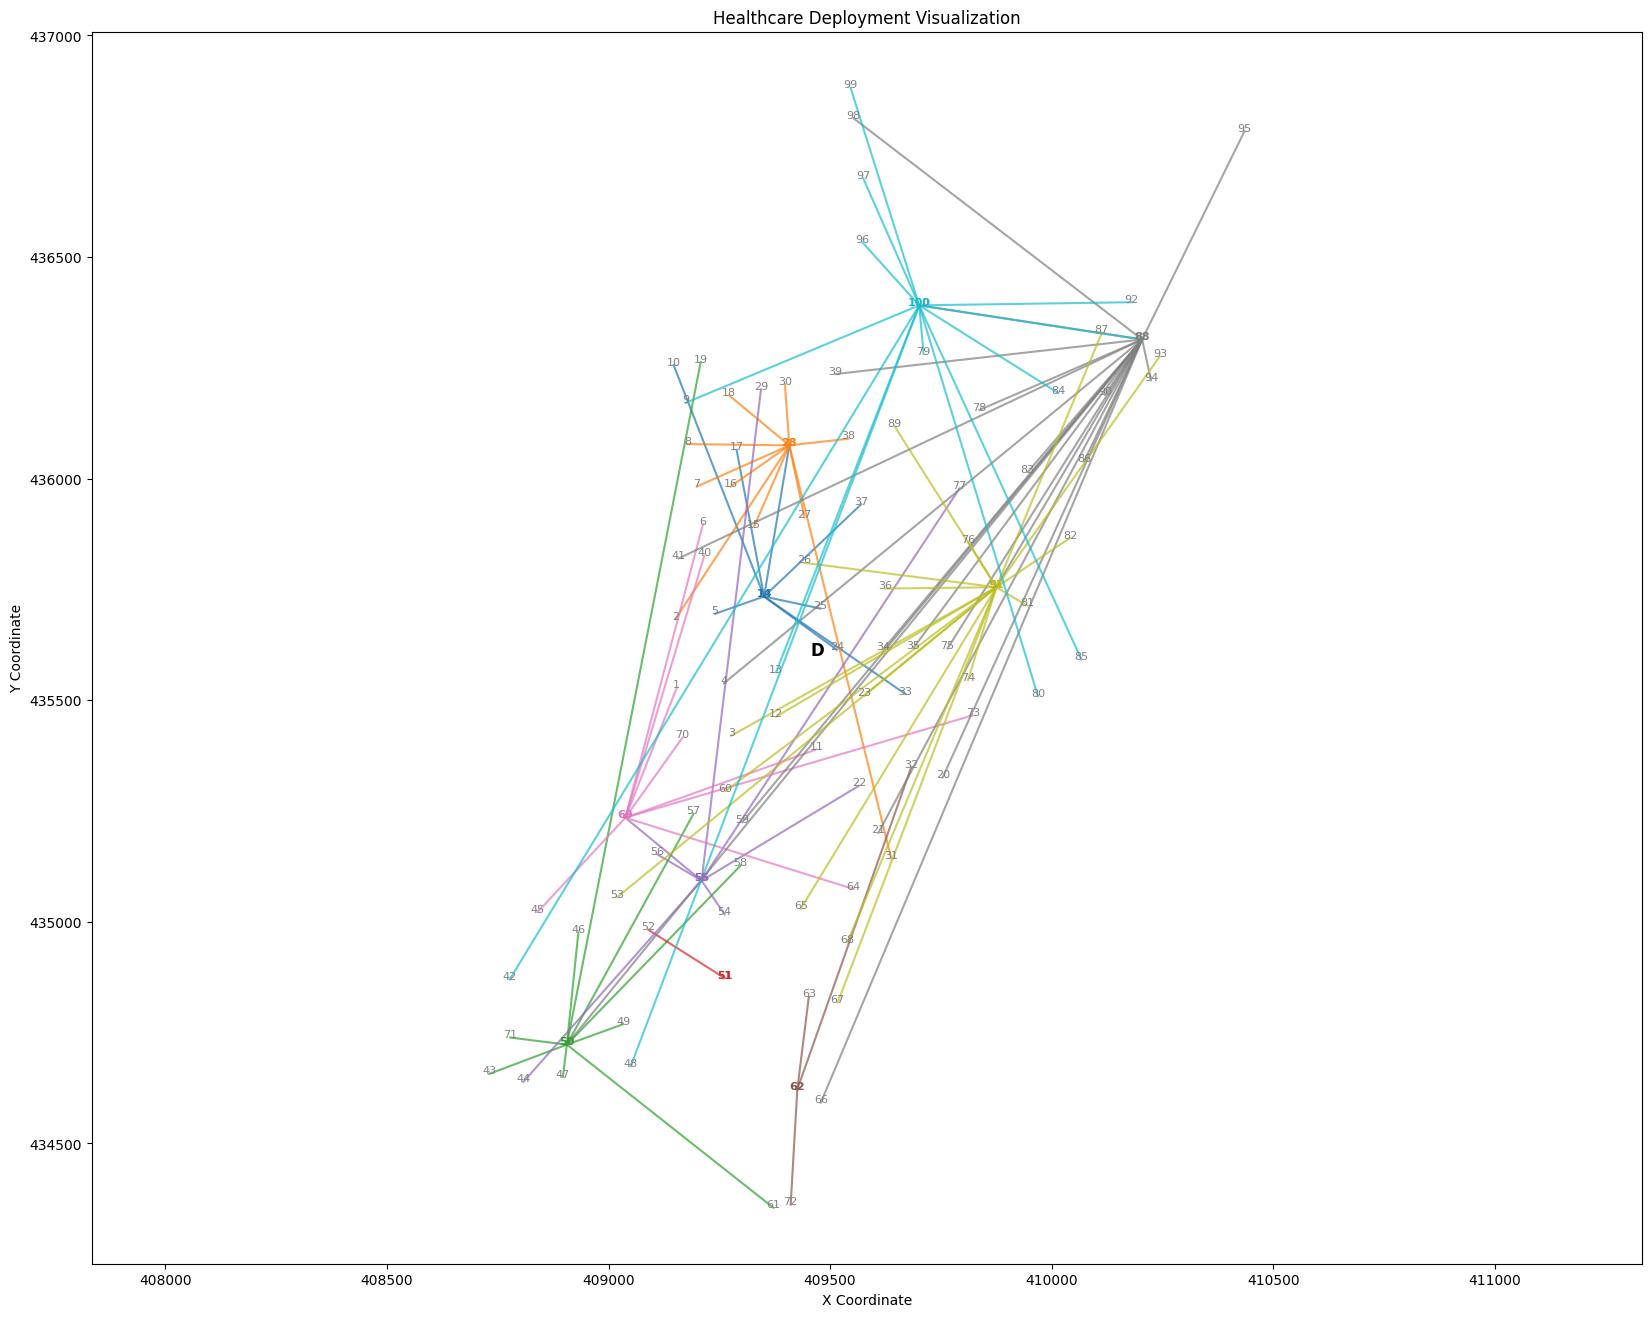

In [8]:
def plot_solution(communities, healthcare_units, assignments, depot):
    plt.figure(figsize=(20, 16))
    colors = plt.get_cmap("tab10")

    # Scale axis to 1:1 ratio
    plt.axis("equal")

    # Plot communities with labels
    for idx, data in communities.items():
        plt.text(data['coords'][0], data['coords'][1], str(int(idx)), fontsize=8, ha='center', color='gray')

    # Plot healthcare units and assign colors
    for i, hc in enumerate(healthcare_units):
        hc_color = colors(i / len(healthcare_units))
        plt.text(communities[hc]['coords'][0], communities[hc]['coords'][1], str(int(hc)), fontsize=8, ha='center', color=hc_color, fontweight='bold')

        # Assign communities to units
        max_d = 0
        max_d_assigned = None
        for assigned in assignments[hc]:
            plt.plot([communities[hc]['coords'][0], communities[assigned]['coords'][0]],
                     [communities[hc]['coords'][1], communities[assigned]['coords'][1]],
                     color=hc_color, linestyle='-', alpha=0.7)
            if distance_matrix[(hc, assigned)]*populations[assigned] > max_d:
                max_d = distance_matrix[(hc, assigned)]*populations[assigned]
                max_d_assigned = assigned
            #print(assigned, "assigned to hc.", hc, "with weight", distance_matrix[(hc, assigned)]*populations[assigned])
        #plt.plot([communities[hc]['coords'][0], communities[max_d_assigned]['coords'][0]],
                     #[communities[hc]['coords'][1], communities[max_d_assigned]['coords'][1]],
                    # color=hc_color, linestyle='-', alpha=(distance_matrix[(hc, assigned)]*populations[assigned])/D_max.x)

    # Plot depot
    plt.text(depot[0], depot[1], "D", fontsize=12, ha='center', color='black', fontweight='bold')

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Healthcare Deployment Visualization")
    plt.show()

# Plot the solution
plot_solution(communities, healthcare_units, assignments, depot)

# Stage 2
---

## Mathematical Formulartion

**Decision Variables**

$z_{ij}$ — Binary variable, equal to 1 if an ambulance travels from healthcare unit $i$ to unit $j$.


$u_j$ — Continuous variable representing the load (equipment demand) delivered to unit $j$.

**Parameters**

$H$ — Set of deployed healthcare units (determined in Stage 1).

$Q=10,000$ — Capacity of each ambulance.

$D_{ij}$ — Euclidean distance between units $i$ and $j$.

$R_j$ — Equipment demand for healthcare unit $j$ (determined by population served).

**Objective Function**
$$\text{min} ⁡\Sigma_{i∈H∪\{0\},j∈H} D_{ij}  z_{ij}
$$

This minimizes the total distance traveled by ambulances.

**Constraints**
1.


Every healthcare unit must be visited exactly once:
$$\Sigma_{i∈H∪\{0\}} z_{ij} = 1, \quad ∀j∈H
$$

---
2.


Every deployed healthcare unit must be reached from the depot or another unit:
$$\Sigma_{j∈H} z_{0j} \leq K
$$
where $K$ is the maximum number of ambulances (determined dynamically).

---
3.


Flow conservation constraint (ensures that an ambulance that enters a unit must also leave):
$$\Sigma_{i∈H∪\{0\}} z_{ij} = \Sigma_{k∈H} z_{jk}, \quad ∀j∈H
$$

---
4.


Capacity constraint for each ambulance:
$$u_j​ \geq R_j​, \quad ∀j∈H
$$
$$u_i−u_j+Q⋅z_{ij}≤Q, \quad ∀i,j∈H
$$

---
5.


Subtour elimination:
$$u_i−u_j+Q⋅z_{ij}≤Q−R_j, \quad ∀i,j∈H
$$

This prevents cycles in the route.


## Code

In [9]:
# The distance matrix needs to be remade to include the hub.
def make_distance_matrix_p2(file_path, HcUnits):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    N, M = map(int, lines[0].split())
    depot = tuple(map(float, lines[1].split()[1:]))

    communities = {}
    populations = {}
    communities[0] = {'coords': depot, 'capacity': 0, 'population': 0}
    for line in lines[2:]:
        values = list(map(float, line.split()))
        node_index, x, y, capacity, population = values
        communities[node_index] = {'coords': (x, y), 'capacity': capacity, 'population': population}
        populations[node_index] = population

    # Compute distance matrix
    distance_matrix = {
        (i, j): euclidean_distance(communities[i]['coords'], communities[j]['coords'])
        for i in [0] + HcUnits for j in [0] + HcUnits
    }

    return N, M, depot, communities, populations, distance_matrix
N, M, depot, communities, populations, distance_matrix = make_distance_matrix_p2(filepath, healthcare_units)
# Extract deployed healthcare units and demand
Q = 10000
H_no_hub = healthcare_units
H = [0] + healthcare_units
demand = {j: sum(int(populations[i+1]) * x[i, j-1].x for i in range(N)) for j in healthcare_units}
demand[0] = 0
K = M
print(H)

# Stage 2: Equipment Distribution Optimization
model2 = gp.Model("Equipment_Distribution")

z = model2.addVars( H, H, vtype=GRB.BINARY, name="z")
u = model2.addVars( H, vtype=GRB.CONTINUOUS, name="u")

model2.setObjective(gp.quicksum(distance_matrix[i, j] * z[i, j] for i in H for j in H), GRB.MINIMIZE)

for j in [0]:
    model2.addConstr(gp.quicksum(z[i, j] for i in H_no_hub if i != j) <= K)
    model2.addConstr(gp.quicksum(z[j, k] for k in H_no_hub if k != j) <= K) # this one is inferred, it is redundant
    model2.addConstr(u[j] >= demand[j])

for j in H_no_hub:
    model2.addConstr(gp.quicksum(z[i, j] for i in H if i != j) == 1)
    model2.addConstr(gp.quicksum(z[j, k] for k in H if k != j) == 1)

for i in H_no_hub:
    model2.addConstr(u[i] >= demand[i])
    model2.addConstr(u[i] <= Q)
    for j in H_no_hub:
        if i != j:
            model2.addConstr(u[i] - u[j] + Q * z[i, j] <= Q - demand[j])

model2.optimize()

# Print results
soln_route_pairs = []

if model2.status == GRB.OPTIMAL:
    print("Optimal Equipment Distribution Routes:")
    for i in H:
        for j in H:
            if z[i, j].x > 0.5:
                #print(f"Ambulance travels from {i} to {j}")
                soln_route_pairs.append((i,j))
    soln_routes = extract_routes(soln_route_pairs)
    write_solution(writepath, filepath, healthcare_units, assignments, D_max.x, routes=soln_routes, stage2_obj=model2.ObjVal)
else:
    print("No optimal solution found.")

# model2.display()


[0, 14, 28, 50, 51, 55, 62, 69, 88, 91, 100]
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11+.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 133 rows, 132 columns and 511 nonzeros
Model fingerprint: 0x310805ec
Variable types: 11 continuous, 121 integer (121 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 10411.554241
Presolve removed 23 rows and 32 columns
Presolve time: 0.01s
Presolved: 110 rows, 100 columns, 906 nonzeros
Variable types: 10 continuous, 90 integer (90 binary)
Found heuristic solution: objective 8113.2389715

Root relaxation: objective 4.131563e+03, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective B

## Plot Soln

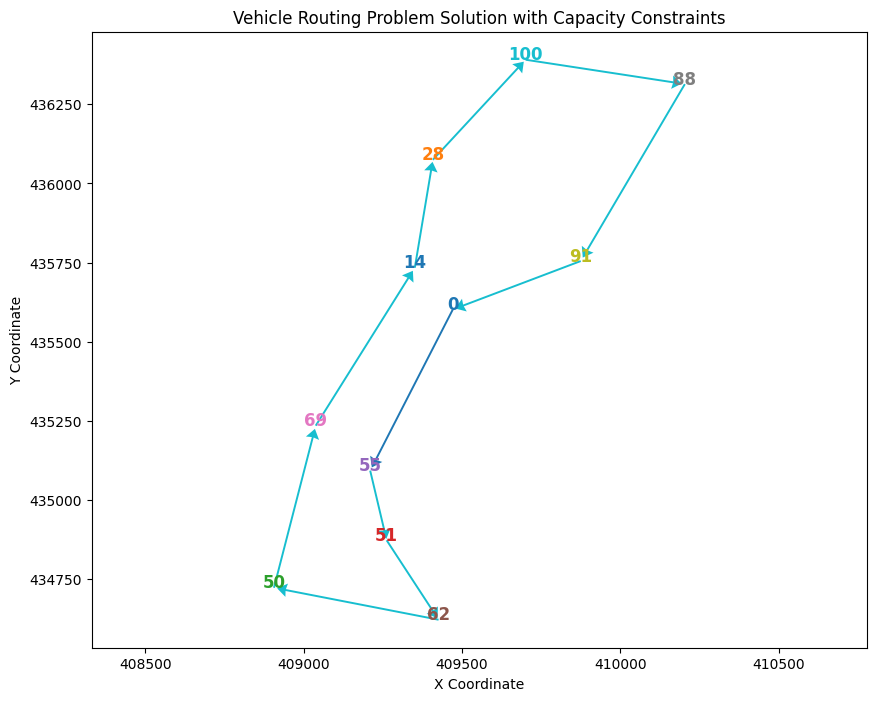

In [10]:
def plot_vrp_solution(communities, depot, z, H):
    plt.figure(figsize=(10, 8))
    colors = plt.get_cmap("tab10")

    # Scale axis to 1:1 ratio
    plt.axis("equal")

    # Plot depot
    #plt.scatter(depot[0], depot[1], marker='s', color='black', s=0, label='Depot')
    #plt.text(depot[0], depot[1], "D", fontsize=12, ha='center', color='black', fontweight='bold')

    # Plot healthcare units and assign colors
    for i, hc in enumerate(H):
        hc_color = colors(i / len(H))
        plt.text(communities[hc]['coords'][0], communities[hc]['coords'][1], str(hc), fontsize=12, ha='center', color=hc_color, fontweight='bold')

    # Plot vehicle routes with arrows
    for i in H:
        for j in H:
            if i != j and z[i, j].x > 0.5:
                route_color = colors(i / len(H))
                dx = communities[j]['coords'][0] - communities[i]['coords'][0]
                dy = communities[j]['coords'][1] - communities[i]['coords'][1]
                plt.quiver(communities[i]['coords'][0], communities[i]['coords'][1],
                           dx, dy, angles='xy', scale_units='xy', scale=1.02,
                           color=route_color, width=0.0025, headwidth=7, headlength=5)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Vehicle Routing Problem Solution with Capacity Constraints")
    plt.show()
plot_vrp_solution(communities, depot, z, H)